### Note : my method with same params gets 3 % higher than sklearns implementation but its takes 10s to train where as sklearns implementation takes less than a 1s

In [2]:
from sklearn import datasets 
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
from scipy import stats
from tqdm import tqdm

data = datasets.load_boston()
data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
data['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [5]:
X,Y = data['data'],data['target']

# Sklearn Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn import tree
model = DecisionTreeRegressor(max_depth = 5,min_impurity_split= 1e-7,random_state=11)
model.fit(X,Y)
r2_score(Y,model.predict(X))

c:\users\clive\appdata\local\programs\python\python37\lib\site-packages\sklearn\tree\_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


0.918973150084058

In [19]:
model.feature_importances_

array([0.03254249, 0.        , 0.        , 0.        , 0.0288244 ,
       0.65717545, 0.        , 0.0721473 , 0.        , 0.        ,
       0.        , 0.        , 0.20931036])

In [14]:
model.max_features_

13

In [16]:
model.tree_

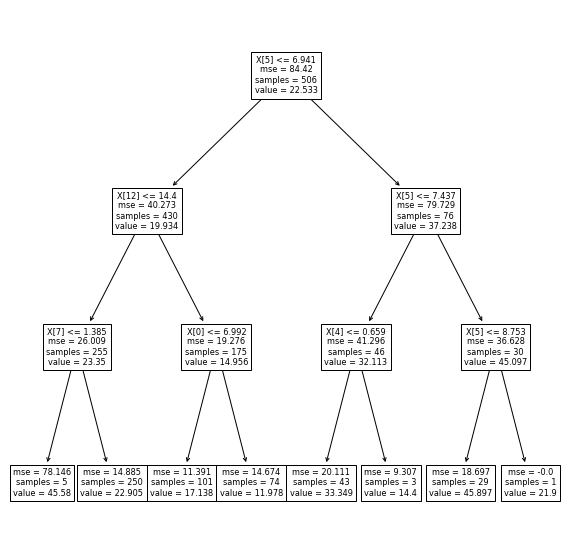

In [20]:
import matplotlib.pyplot as plt 

plt.figure(figsize =  (10,10))
tree.plot_tree(model);

In [21]:
DecisionTreeRegressor?

In [38]:
class DecisionNode:
    
    def __init__(self,feature = None,
                     entropy = None,threshold = None,
                     value = None,right=None,left=None):   
            
            self.entropy = entropy
            
            self.feature = feature
             
            self.right = right
            
            self.left = left
            
            self.threshold = threshold
            
            self.value = value

# function to find feature to split on 

def divide_on_feature(X, feature_i, threshold):

    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])






class DecisionTreeRegressior:
    
    
    def __init__(self, min_samples_split=3, min_impurity=1e-7,
                 max_depth= 5,criterian = 'mse'):
        
        #contains the root of the tree 
        self.root = None         
        self.criterian = criterian
        #stopping conditions 
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        
        
        
        
    def fit(self,X,y):

        self.root  = self._build_tree(X,y)
        
    
        
    def _build_tree(self, X, y, current_depth=0):
 
        largest_impurity = 0
        best_criteria = None    # Feature index and threshold
        best_sets = None     # Subsets of the data
        right = None 
        left= None
        selected_feature = None
        selected_threshold = None
        
        # Check if expansion of y is needed
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        # Add y as last column of X
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        
        if n_samples >= self.min_samples_split and self.max_depth >= current_depth:
            
#             print(current_depth)
            
            # Calculate the impurity for each feature
            for feature_i in range(n_features):
                
                # All values of feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                # Iterate through all unique values of feature column i and
                # calculate the impurity
                for threshold in unique_values:
                    # Divide X and y depending on if the feature value of X at index feature_i
                    # meets the threshold
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Select the y-values of the two sets
                        y1 = Xy1[:,-1]
                        y2 = Xy2[:,-1]

                        # Calculate impurity
                        
                        impurity = self.variance_reduction(y, y1, y2)
#                      

                        # If this threshold resulted in a higher information gain than previously
                        # recorded save the threshold value and the feature
                        # index
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            selected_feature = feature_i
                            selected_threshold = threshold 
                            right,left = Xy2,Xy1
    
    
        if largest_impurity > self.min_impurity:
            # Build subtrees for the right and left branches
            left = self._build_tree(left[:,:-1], left[:,-1], current_depth = current_depth + 1)
            right = self._build_tree(right[:,:-1], right[:,-1], current_depth = current_depth + 1)
            return DecisionNode(feature=selected_feature, threshold=selected_threshold, left=left, right=right)

        # We're at leaf => determine value
        leaf_value = self.mean_leaf(y)

        return DecisionNode(value=leaf_value)
    
    
    def mean_leaf(self,y):
        
        return np.mean(y)
    

    def variance_reduction(self,y,y1,y2):
    
        frac1 = len(y1)/ len(y)
        frac2 = len(y2)/ len(y)

        return np.var(y) - frac1 * np.var(y1) - frac2 * np.var(y2)



    def predict_value(self, x, tree=None):
        

        if tree is None:
            tree = self.root

        if tree.value is not None:
            return tree.value

        feature_value = x[tree.feature]

        # Determine if we will follow left or right branch
        branch = tree.right
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.left
        elif feature_value == tree.threshold:
            branch = tree.left


        # Test subtree
        return self.predict_value(x, branch)

        
    def predict(self,X):
        
        y_pred = [self.predict_value(sample) for sample in X]
         
        return y_pred
        
      
m  = DecisionTreeRegressior()        
m.fit(X,Y)
r2_score(Y,m.predict(X))

0.9439799933751332